In [0]:
import keras
keras.__version__

'2.0.8'

In [0]:
from keras import backend as K
K.clear_session()

# 変分オートエンコーダによる画像の生成

GANとVAEは音声、音楽、テキストの潜在空間の開発にも使用できる。
画像生成の鍵は「表現からなる低次元の潜在空間を開発する」という考え方。エンコーダ、デコーダがマッピングを行う。


参考    
https://arxiv.org/pdf/1312.6114.pdf
    
https://qiita.com/iss-f/items/c43b23815fc6d15ae22e
    
https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24

## 画像の潜在空間からのサンプリング

VAEはディープラーニングにベイズ推定をミックスした現代的なオートエンコーダ。

従来オートエンコーダは元の入力画像を復元するために学習する。エンコーダ出力に制約を課すことで、データの興味深い潜在表現をオートエンコーダに学習させれる。一般的なのはコードを低次元の疎な空間に制約すること。


![Autoencoder](https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg)

一般的なオートエンコーダによって生成される潜在空間は、特に有益でもなければ、うまく構造化されているわけでもないので時代遅れになっている。VAEは統計の力でうまく構造化された連続的な潜在空間を学習できる。

VAEは入力画像を潜在空間の固定のコードに圧縮するのではなく、統計分布のパラメータ（平均と分散）に変換。平均分散パラメータを使って分布から1つの要素をランダム抽出し、元入力をデコードする。このプロセスの確率性により、潜在空間がどの場所でも意味を密表現をエンコードするようになる。

![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)

VAEの仕組み

1.  エンコーダモジュールにより、入力画像input_imgが表現の潜在空間の2つのパラメータz_meanとz_log_varianceに変換される。
2. 入力画像がz = z_mean + exp(z_log_variance) * epsilon で生成されると仮定し、潜在空間の正規分布から点zをランダムに抽出する。epsilonは小さな値のランダムテンソル。
3. デコーダモデルにより、潜在空間のこの点が元の入力画像に写像される。


epsilonが乱数なので入力の潜在空間に近い点は似ている何かにデコードできるようになるので、連続的に意味を持つものになる。

VAEのパラメータは復元損失と正則化損失という2つの損失関数によって訓練される。


In [0]:
# # 入力を平均パラメータと分散パラメータにエンコード
# z_mean, z_log_variance = encoder(input_img)

# # 小さい乱数値のepsilonを使って潜在空間の点zを抽出
# z = z_mean + exp(z_log_variance) * epsilon

# # zを画像にデコード
# reconstructed_img = decoder(z)

# # オートエンコーダモデルをインスタンス化
## モデルは入力画像をその復元された画像に写像する
# model = Model(input_img, reconstructed_img)

あとは復元損失と正則化損失を使ってネットワークを訓練する。画像を潜在空間の確率分布のパラメータにマッピングする。このネットワークは単純なCNNで、入力画像xを2つのベクトルz_meanとz_log_varにマッピングする。

In [2]:
#VAEエンコーダネットワーク
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x) #ここ
z_log_var = layers.Dense(latent_dim)(x) #ここ

Using TensorFlow backend.


input_imgを生成したと仮定される統計分布のパラメータz_mean、z_log_varを使用するコードは下記のようになる。
このパラメータは、潜在空間の点zを生成する為に使用。kerasでは全てのものが層でないとならない。組込み層の一部はLambda（またはカスタム層）にまとめる必要がある。


In [0]:
#潜在空間サンプリング関数
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [0]:
# この入力でzを供給
decoder_input = layers.Input(K.int_shape(z)[1:])

# 入力を正しい数のユニットにアップサンプリング
# numpy.prodは積
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 最後のFlatten層の直前の特徴マップと同じ形状の特徴マップに変換
x = layers.Reshape(shape_before_flattening[1:])(x)

# Conv2DTranspose層とConv2D層を使って元の入力画像と同じサイズの特徴マップに変換
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

VAEの2つの損失関数はloss(input, target)形式のサンプルごとに関数という従来の期待に反している。そこで損失関数を準備するためにカスタム層を作成。add_lossを使って任意の損失関数を作成する。

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# カスタム層を呼び出し、最終的なモデル出力を取得するための入力と
# デコードされた出力を渡す。
y = CustomVariationalLayer()([input_img, z_decoded])

損失関数はカスタム層によって処理されるので、コンパイル時に外部の損失関数をしている必要はない(loss=None)。訓練の際に目的値は渡さない。fitに渡すのはx_trainだけ。

In [6]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

11493376/11490434 [==============================] - 3s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
31296/60000 [==============>...............] - ETA: 26s - loss: 350599.4878

60000/60000 [==============================] - 56s 932us/step - loss: 182872.7889 - val_loss: 0.1973
Epoch 2/10
23248/60000 [==========>...................] - ETA: 31s - loss: 0.1959

60000/60000 [==============================] - 53s 891us/step - loss: 0.1941 - val_loss: 0.1899
Epoch 3/10
21584/60000 [=========>....................] - ETA: 32s - loss: 0.1903

60000/60000 [==============================] - 53s 891us/step - loss: 0.1894 - val_loss: 0.1896
Epoch 4/10
20880/60000 [=========>....................] - ETA: 33s - loss: 0.1871

60000/60000 [==============================] - 54s 897us/step - loss: 0.1869 - val_loss: 0.1859
Epoch 5/10
20624/60000 [=========>....................] - ETA: 33s - loss: 0.1858

60000/60000 [==============================] - 54s 894us/step - loss: 0.1852 - val_loss: 0.1854
Epoch 6/10
20480/60000 [=========>....................] - ETA: 33s - loss: 0.1847

60000/60000 [==============================] - 54s 897us/step - loss: 0.1841 - val_loss: 0.1829
Epoch 7/10
20496/60000 [=========>....................] - ETA: 33s - loss: 0.1826

60000/60000 [==============================] - 53s 890us/step - loss: 0.1831 - val_loss: 0.1833
Epoch 8/10
20480/60000 [=========>....................] - ETA: 33s - loss: 0.1830

60000/60000 [==============================] - 53s 887us/step - loss: 0.1822 - val_loss: 0.1819
Epoch 9/10
20480/60000 [=========>....................] - ETA: 33s - loss: 0.1820

60000/60000 [==============================] - 54s 898us/step - loss: 0.1815 - val_loss: 0.1827
Epoch 10/10
20336/60000 [=========>....................] - ETA: 33s - loss: 0.1810

60000/60000 [==============================] - 53s 889us/step - loss: 0.1810 - val_loss: 0.1809


モデルを訓練した後はデコーダモデルで任意の潜在空間のベクトルを画像に変換できる。

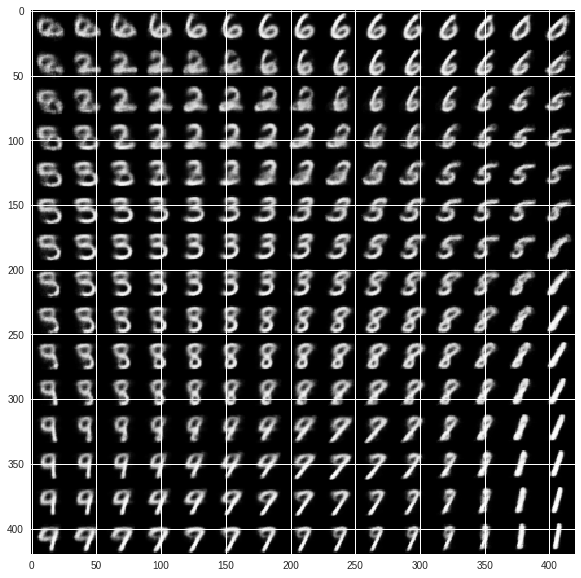

In [7]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# scipyのppf関数を使って線型空間座標を変換し、潜在変数zを生成。
#（潜在空間の前はガウス分布であるため）
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

サンプリングされた数字からなるグリッドは、様々な数字クラスの分布が完全に連続していることを示す。潜在空間のパスを辿ってみると、数字が別の数字にモーフィングしている。この空間では特定の向きが意味を持っている。４らしさを持つ向きや、１らしさを持つ向きが存在する。

VAEではうまく構造化された連続的な潜在空間が得られる。顔を入れ替えたり、不機嫌な顔を笑顔に変えたり、あらゆる種類の画像編集を潜在空間で行うのに適する。また、潜在空間の断面に沿って移動するアニメーションや、ある画像から別の画像への緩やかな途切れのないモーフィングなど潜在空間ベースのアニメーションにも適する。
    
GNではリアルなシングルフレーム画像の生成が可能だが、しっかりとした構造と高い連続を持つ潜在空間に結びつかないことがある。

